# Final Assignment (from Yuxi 23-05-23)

In this lexical decision task, participants are auditorily presented with a word (high- versus low-frequency word and nonword stimuli) for a given period of time, and asked to respond whether they think it is a real word (or not). 

First I set up a virtual environment again with `python -m venv .venv` and `source .venv/bin/activate` from the terminal and  make sure I am in the current virtual environment (indicated by the line starting with `(.venv)`). Psychopy is then installed with `pip install -r requirements.txt` in session 3.

In [62]:
from PsychoPy import visual, sound, core # no tobii-research for Mac with M1 silicon

ModuleNotFoundError: No module named 'PsychoPy'

# Auditory Lexical Decision Experiment

First, I extract LF and HF word and nonword stimuli from original recordings.

In [ ]:
import os, csv
from pydub import AudioSegment, silence, effects
path_to_repository = "./stimuli"

stimuli_info = open(os.path.join(path_to_repository, "lexical_decision_stimuli.csv"))
stimuli_reader = csv.reader(stimuli_info, delimiter=',')
headers = next(stimuli_reader, None)

stimuli = {}
for stimulus in stimuli_reader:
    if stimulus[2] not in stimuli.keys():
        stimuli[stimulus[2]] = list()
    stimuli[stimulus[2]].append(stimulus[3])

# LF word condition
sound_folder = "./stimuli"
sound_path = os.path.join(sound_folder, "LF_recording.wav")
sound = AudioSegment.from_wav(sound_path)

target_volume = -6
save_folder = "./stimuli/stimLF"
os.mkdir(save_folder)

LF_words = silence.split_on_silence(sound, min_silence_len=100, silence_thresh=-50)

for item in range(len(stimuli['LF'])):
    extract_segment = LF_words[item]
    target_segment  = extract_segment.apply_gain(target_volume)
    
    save_name = os.path.join(save_folder, stimuli['LF'][item]+'.mp3')
    target_segment.export(save_name, format="mp3")
    
# HF word condition
sound_path = os.path.join(sound_folder, "HF_recording.wav")
sound = AudioSegment.from_wav(sound_path)

save_folder = "./stimuli/stimHF"
os.mkdir(save_folder)

HF_words = silence.split_on_silence(sound, min_silence_len=100, silence_thresh=-50)

for item in range(len(stimuli['HF'])):
    extract_segment = HF_words[item]
    target_segment  = extract_segment.apply_gain(target_volume)
    
    save_name = os.path.join(save_folder, stimuli['HF'][item]+'.mp3')
    target_segment.export(save_name, format="mp3")
    
# Nonword condition
sound_path = os.path.join(sound_folder, "NW_recording.wav")
sound = AudioSegment.from_wav(sound_path)

save_folder = "./stimuli/stimNW"
os.mkdir(save_folder)

HF_words = silence.split_on_silence(sound, min_silence_len=100, silence_thresh=-50)

for item in range(len(stimuli['none'])):
    extract_segment = HF_words[item]
    target_segment  = extract_segment.apply_gain(target_volume)
    
    save_name = os.path.join(save_folder, stimuli['none'][item]+'.mp3')
    target_segment.export(save_name, format="mp3")

During the lexical decision task, participants need to judge whether they heard a real word not. Indeed a yes-response (press Y) is needed for the word stimuli, while a no-response (press N) is needed for the nonword stimuli. 

Each trial begins with a fixation point for 1000 ms, then the auditory stimuli will be presented until any button responses (Y or N) are made. Their responses and reaction times are recorded.

In [ ]:
from psychopy import visual, sound, core, event
import pandas as pd
import numpy as np

# Organize stimuli list
stimuli = pd.read_csv('./stimuli/lexical_decision_stimuli.csv') 

for item in range(len(stimuli['freq_category'])): # unify the freq_category with word type
    if stimuli['freq_category'][item] == 'none':
        stimuli['freq_category'][item] = 'NW' 

stimuli['correct_response'] = {} # define correct response for each condition
for item in range(len(stimuli['freq_category'])):
    if stimuli['condition'][item] == 'rw':
        stimuli['correct_response'][item] = 'Y'
    else: stimuli['correct_response'][item] = 'N' 

rand_stim = stimuli.sample(frac=1) # randomize the stimuli order 

# Set up experiment
window  = visual.Window(size=(400, 400)) # create a visual window for instruction and fixation
message = visual.TextStim(window)
buttons = {'Y','N'}
results = []

# Display instructions
message.text = 'In this task you need to judge whether the word your heard is a real word or not. Press Y when the word is real word, Press N when the word not.' # Instructions
message.draw()
window.flip()
event.waitKeys() # wait for any button press

clock = core.Clock()  # create a clock to measure response times

# Loop trials with all stimuli
for trial in range(len(rand_stimuli)):
    
    audio_name = rand_stim['word'][trial] # pre-load auditory stimuli
    audio_cond = rand_stim['freq_category'][trial]
    audio_path = os.path.join("./stimuli",'stim'+ audio_cond, audio_name +'.mp3')
    audio = sound.Sound(audio_path) 
    
    correct_response = rand_stim[correc][trial]
    
    message.text = '+' # present fixation for one second
    message.draw()
    window.flip()
    core.wait(1.0)
    
    audio.play()  # play the loaded sound
    clock.reset() # reset the clock before each response
    response = event.waitKeys(keyList=buttons)[0]
    response_time = clock.getTime()

    results.append((word, audio_cond, correct_response, response, respinse_time))

# Save current results
participants_number = "1"
output_file_name = "subject" + participants + "_lexical_decision_results"
results_dataframe = pd.DataFrame(results, columns=['Word','Condition','Correct Response', 'Response', 'Response Time'])
results_dataframe.to_csv(output_file_name, index=False)

# Generate Data

Since the psychopy cannot run in the Mac with M1, so I choose to generate data with `generate_data.py` script.

To better understand and illustrate the frequency effect, I choose to keep the mean RT for LF as around 700 ms, but that for HF as around 500 ms. Also, to acheive a lexicality effect, the mean RT for NW is set as around 1000 ms.

In [ ]:
from faker import Faker
from scipy import stats
import numpy as np
import pandas as pd
from random import choices, randint, shuffle
import random

# Generate the participant data

fake = Faker()
mean_age, std_age = 22, 5
participant_structure = {
    'first_name': fake.first_name,
    'last_name': fake.last_name,
    'age': lambda: int(stats.truncnorm.rvs(a=(18 - mean_age) / std_age, b=(80 - mean_age) / std_age, loc=mean_age, scale=std_age)),
    'gender': lambda: choices(['man', 'woman', 'non-binary', 'other'], weights=(0.3, 0.6, 0.05, 0.05))[0],
    'id': lambda: randint(10000, 99999)
}

n_participants = 20
participants = pd.DataFrame([{key: generator() for key, generator in participant_structure.items()} for i in range(n_participants)])
participants.to_csv('participants.csv', index=False)

# Generate the trial data

for participant in range(n_participants):
    
    mean_LF = random.uniform(650, 750)
    mean_HF = random.uniform(450, 550)
    mean_NW = random.uniform(950, 1050)
    sd = random.uniform(50, 150)
    
    conditionLF = np.random.normal(mean_LF, sd, size=len(stimuli[stimuli['freq_category'] == 'LF']))
    conditionHF = np.random.normal(mean_HF, sd, size=len(stimuli[stimuli['freq_category'] == 'HF']))
    conditionNW = np.random.normal(mean_NW, sd, size=len(stimuli[stimuli['freq_category'] == 'NW']))
    
    rand_stim = stimuli.sample(frac=1) # randomize for each participant
    rand_stim['ResponseTime'] = np.nan
    
    rand_stim.loc[rand_stim['freq_category'] == 'LF', 'ResponseTime'] = conditionLF
    rand_stim.loc[rand_stim['freq_category'] == 'HF', 'ResponseTime'] = conditionHF
    rand_stim.loc[rand_stim['freq_category'] == 'NW', 'ResponseTime'] = conditionNW
    
    trial_number = len(rand_stim['stim_id'])
    ACC = np.random.choice([0, 1], size=trial_number, p=[0.25,0.75]) # set all participants' accuracy as 0.75
    rand_stim['Accuracy'] = np.nan
    rand_stim['Accuracy'] = ACC
    
    participants_number = participants['id'][participant]
    rand_stim['id'] = np.nan
    for i in range(len(rand_stim['id'])):
        rand_stim['id'][i] = participants_number
    
    rand_stim.to_csv(f'participants/{participants_number}.csv')

/var/folders/sn/24zjh7r56j11mvkmzbdfdbwh0000gn/T/ipykernel_77477/2615214617.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_stim['id'][i] = participants_number
/var/folders/sn/24zjh7r56j11mvkmzbdfdbwh0000gn/T/ipykernel_77477/2615214617.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_stim['id'][i] = participants_number
/var/folders/sn/24zjh7r56j11mvkmzbdfdbwh0000gn/T/ipykernel_77477/2615214617.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

# Data summary and visualization

In [ ]:
# load the data for each participant

path = os.getcwd() # use current working path
participants = pd.read_csv(os.path.join(path, 'participants.csv'))

trials = pd.DataFrame()
for participant_id in participants['id']:
    participant_data = pd.read_csv(f'participants/{participant_id}.csv')
    trials = pd.concat([trials, participant_data]) 
    
# merge data based on participants id
trials = trials.merge(participants, on='id')
trials = trials.drop('Unnamed: 0', axis=1)

trials.head(-5)

,stim_id,condition,freq_category,word,subtlex_log10freq,correct_response,ResponseTime,Accuracy,id,first_name,last_name,age,gender
0,184,nw,NW,rieve,0.0000,N,1019.049237,1,30133.0,Diana,Stewart,24,man
1,10,rw,LF,sikkels,0.3010,Y,658.987342,1,30133.0,Diana,Stewart,24,man
2,162,nw,NW,gebeikt,0.0000,N,1008.309930,1,30133.0,Diana,Stewart,24,man
3,169,nw,NW,plin,0.0000,N,1015.923597,0,30133.0,Diana,Stewart,24,man
4,34,rw,LF,gonsde,0.7782,Y,753.831310,1,30133.0,Diana,Stewart,24,man
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,150,nw,NW,knaarde,0.0000,N,1103.383940,1,15577.0,Alexandria,Anderson,20,man
3991,4,rw,LF,polders,0.3010,Y,868.766260,1,15577.0,Alexandria,Anderson,20,man
3992,98,rw,HF,had,4.9643,Y,685.337166,1,15577.0,Alexandria,Anderson,20,man
3993,59,rw,HF,redden,3.8783,Y,499.588409,1,15577.0,Alexandria,Anderson,20,man


In [ ]:
# consider lexicality effect

summary = trials.groupby(by='condition').aggregate(
    mean_RT=pd.NamedAgg('ResponseTime', np.mean),
    std_RT=pd.NamedAgg('ResponseTime', np.std),
    mean_ACC=pd.NamedAgg('Accuracy', np.mean),
    std_ACC=pd.NamedAgg('Accuracy', np.std),
    mean_age=pd.NamedAgg('age', np.mean)
)

summary

,mean_RT,std_RT,mean_ACC,std_ACC,mean_age
condition,,,,,
nw,1001.995915,108.139722,0.7635,0.425039,22.65
rw,595.725615,149.121080,0.7565,0.429302,22.65


In [ ]:
# consider frequency effect

summary = trials.groupby(by='freq_category').aggregate(
    mean_RT=pd.NamedAgg('ResponseTime', np.mean),
    std_RT=pd.NamedAgg('ResponseTime', np.std),
    mean_ACC=pd.NamedAgg('Accuracy', np.mean),
    std_ACC=pd.NamedAgg('Accuracy', np.std),
    mean_age=pd.NamedAgg('age', np.mean)
)

summary

,mean_RT,std_RT,mean_ACC,std_ACC,mean_age
freq_category,,,,,
HF,494.192323,108.643312,0.7690,0.421683,22.65
LF,697.258908,109.792647,0.7440,0.436640,22.65
NW,1001.995915,108.139722,0.7635,0.425039,22.65


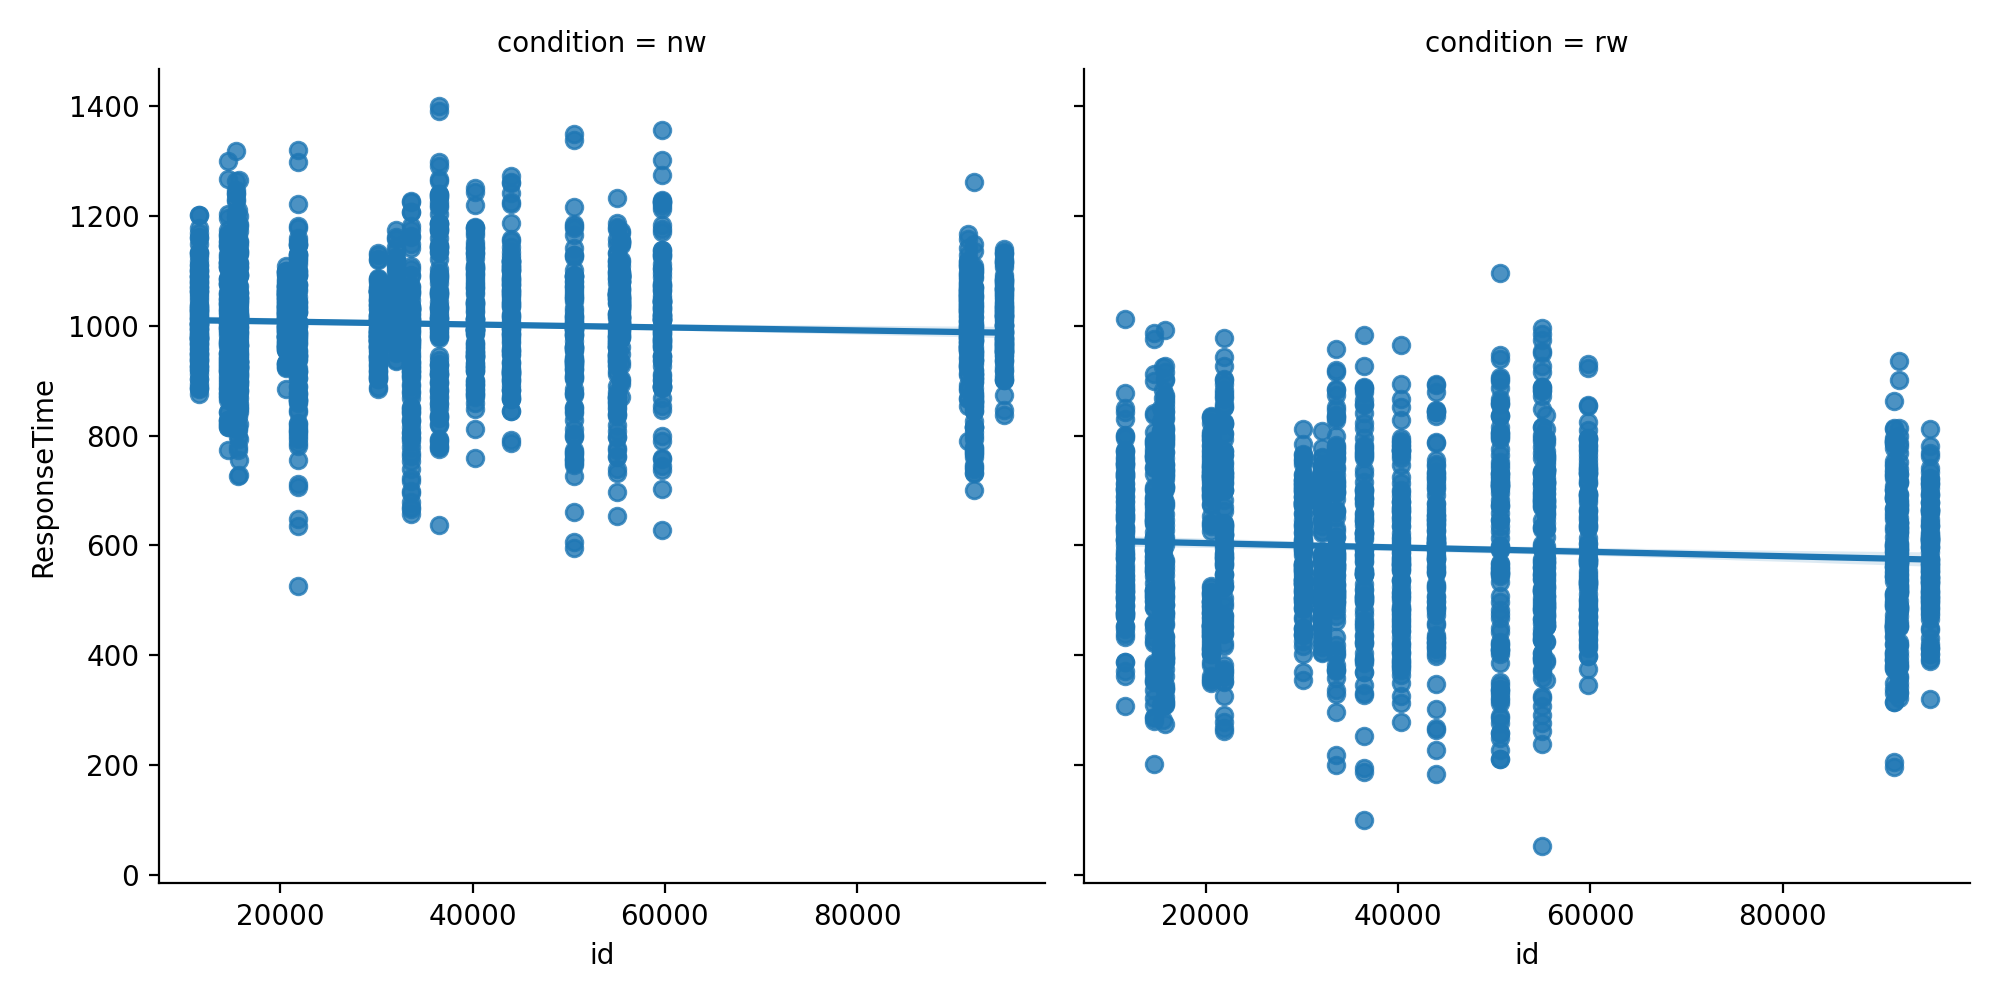

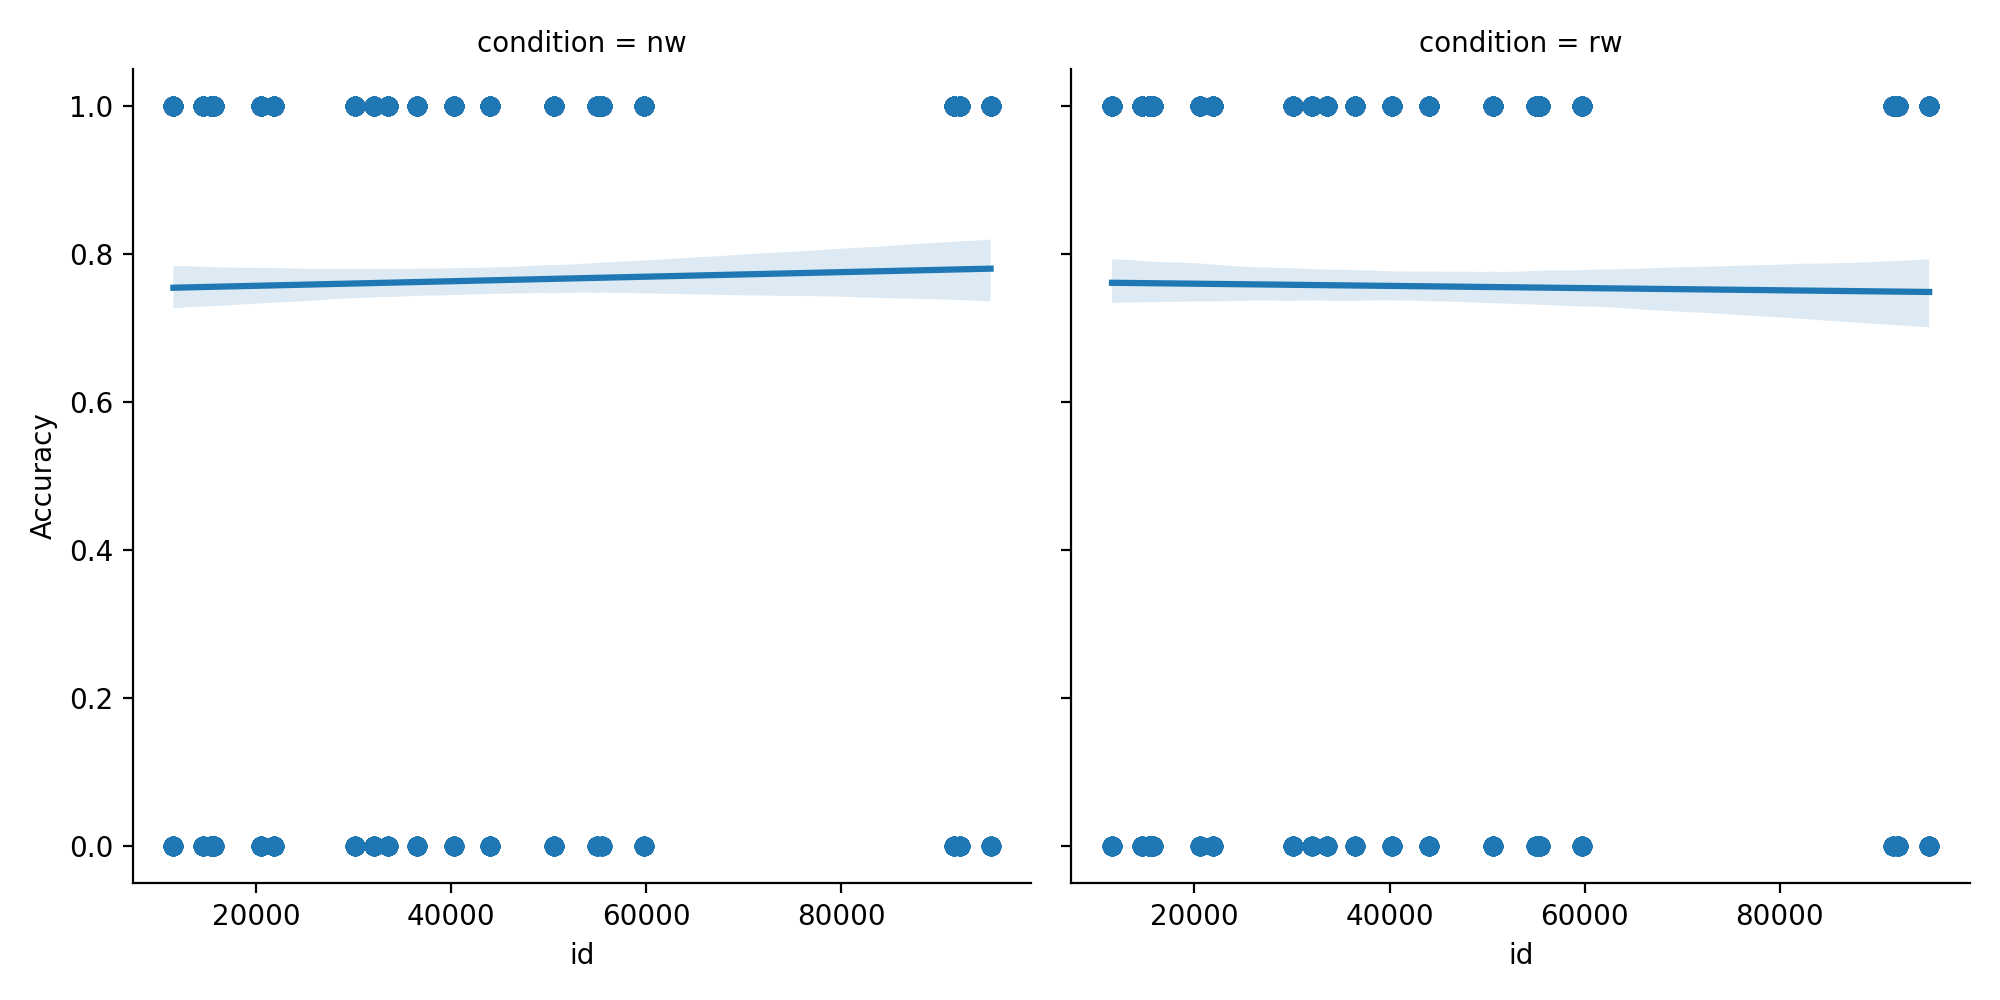

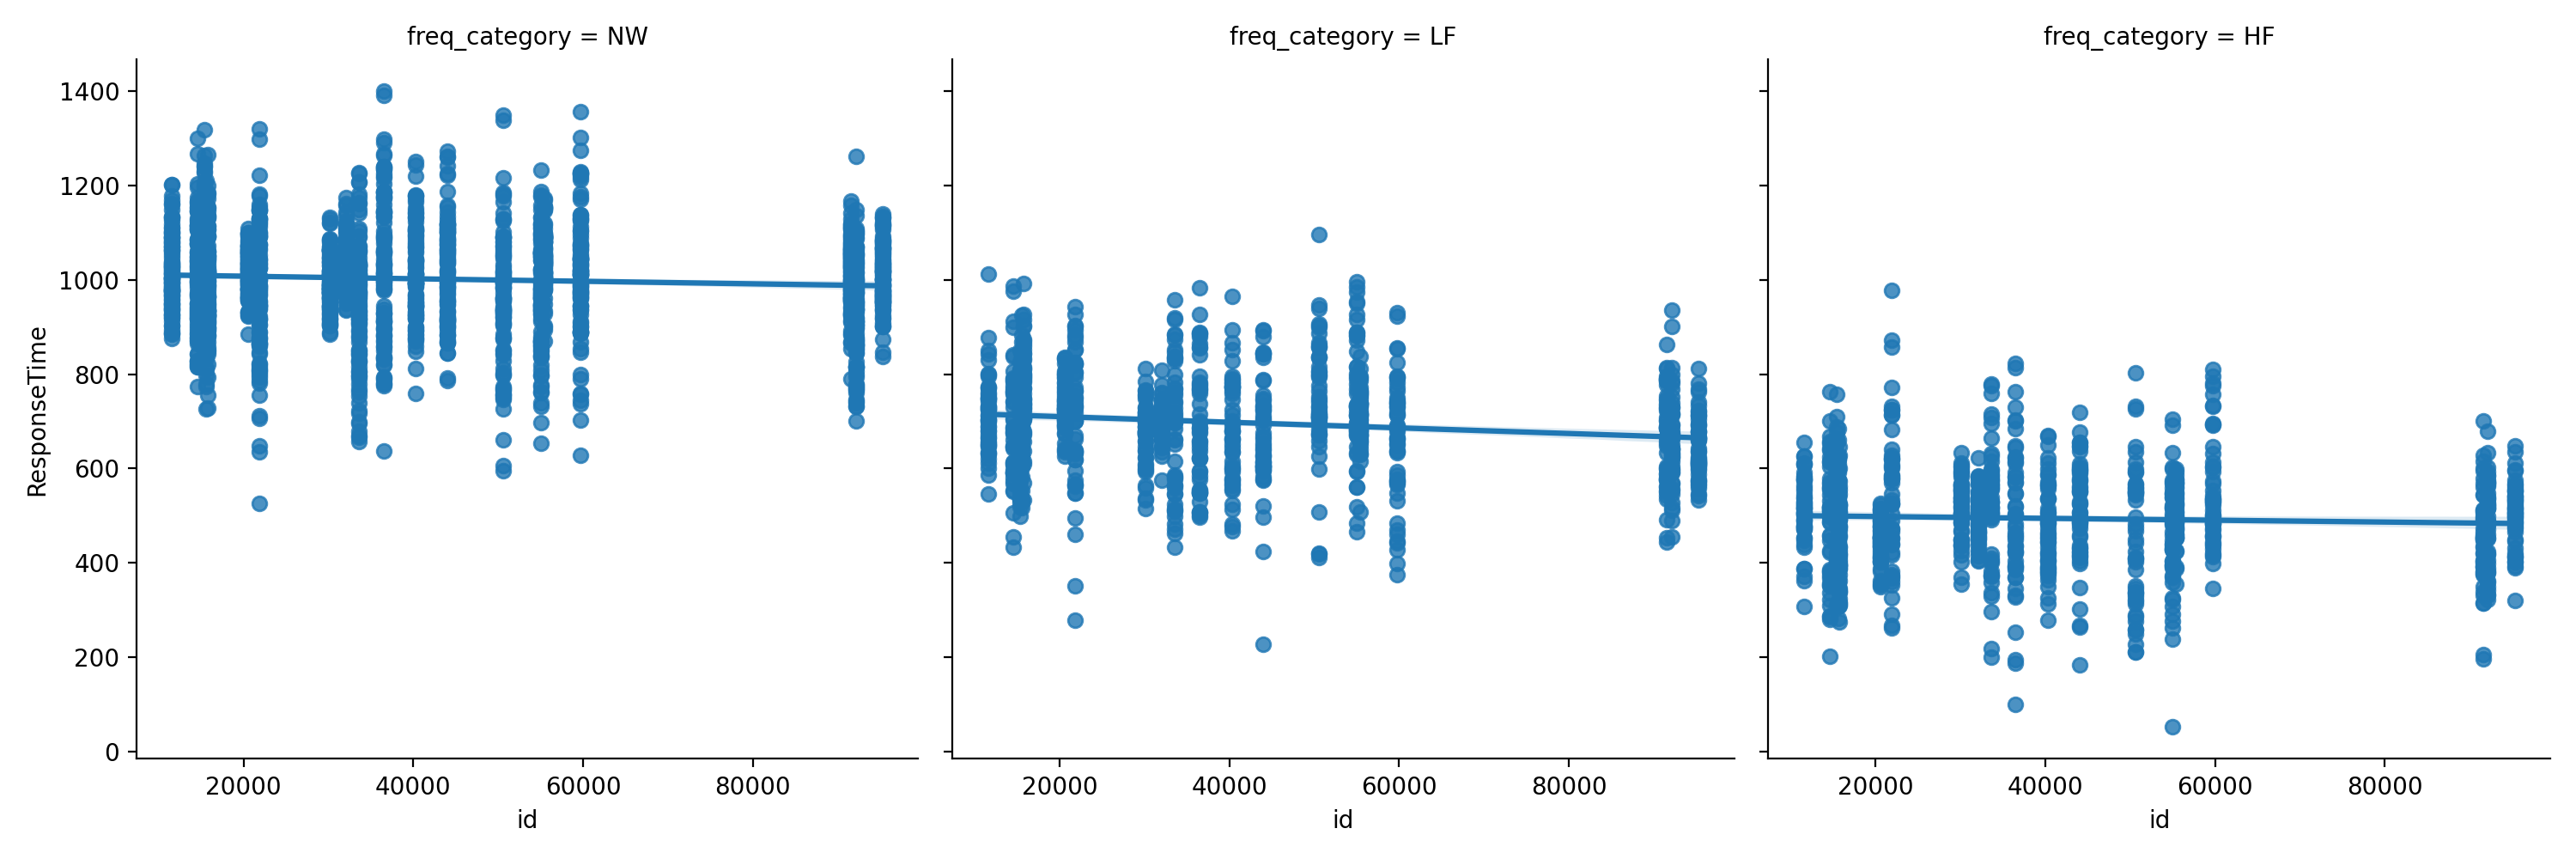

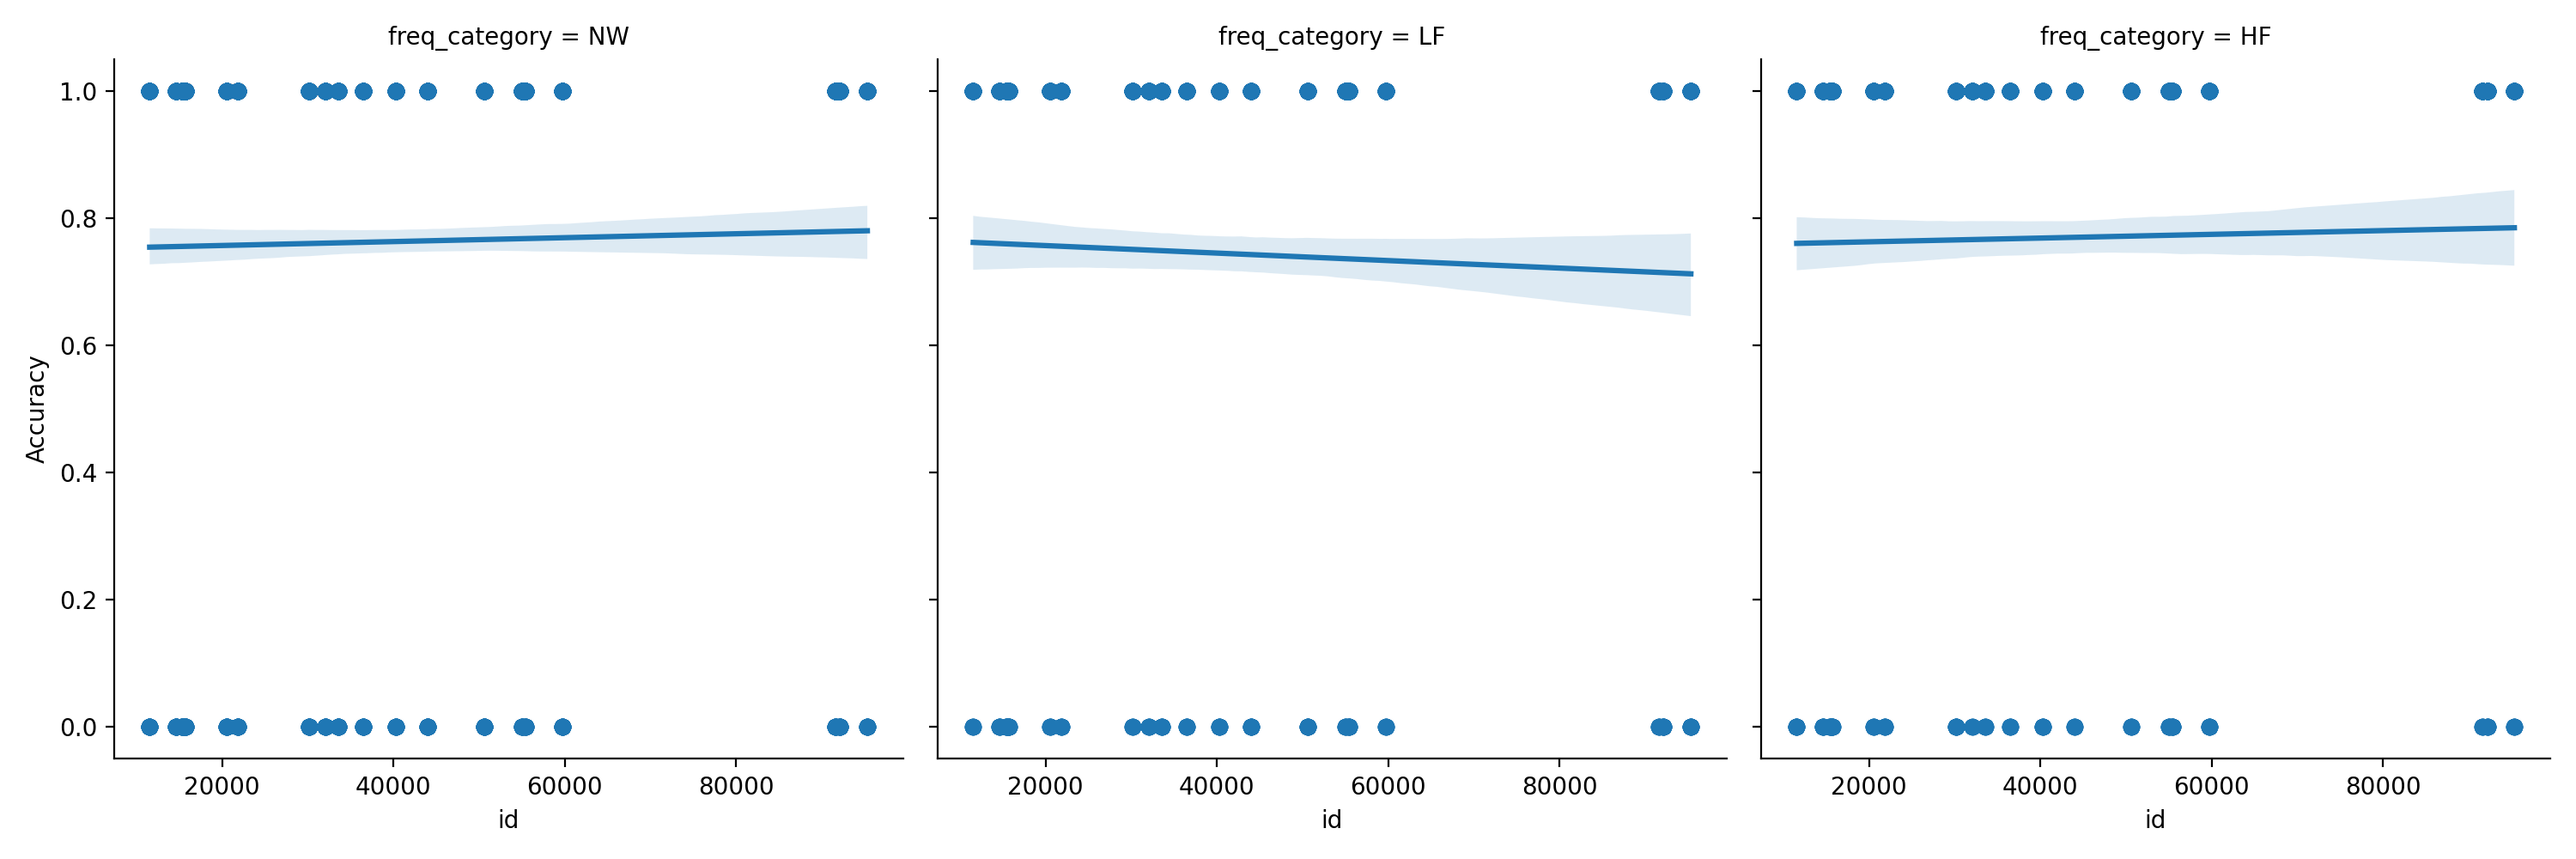

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns 

# Diagnostic plot (scatterplot)

sns.lmplot(x='id', y='ResponseTime', col='condition', data=trials) # for reaction time
plt.show()

sns.lmplot(x='id', y='Accuracy', col='condition', data=trials) # for accuracy
plt.show()

sns.lmplot(x='id', y='ResponseTime', col='freq_category', data=trials) # for reaction time
plt.show()

sns.lmplot(x='id', y='Accuracy', col='freq_category', data=trials) # for accuracy
plt.show()

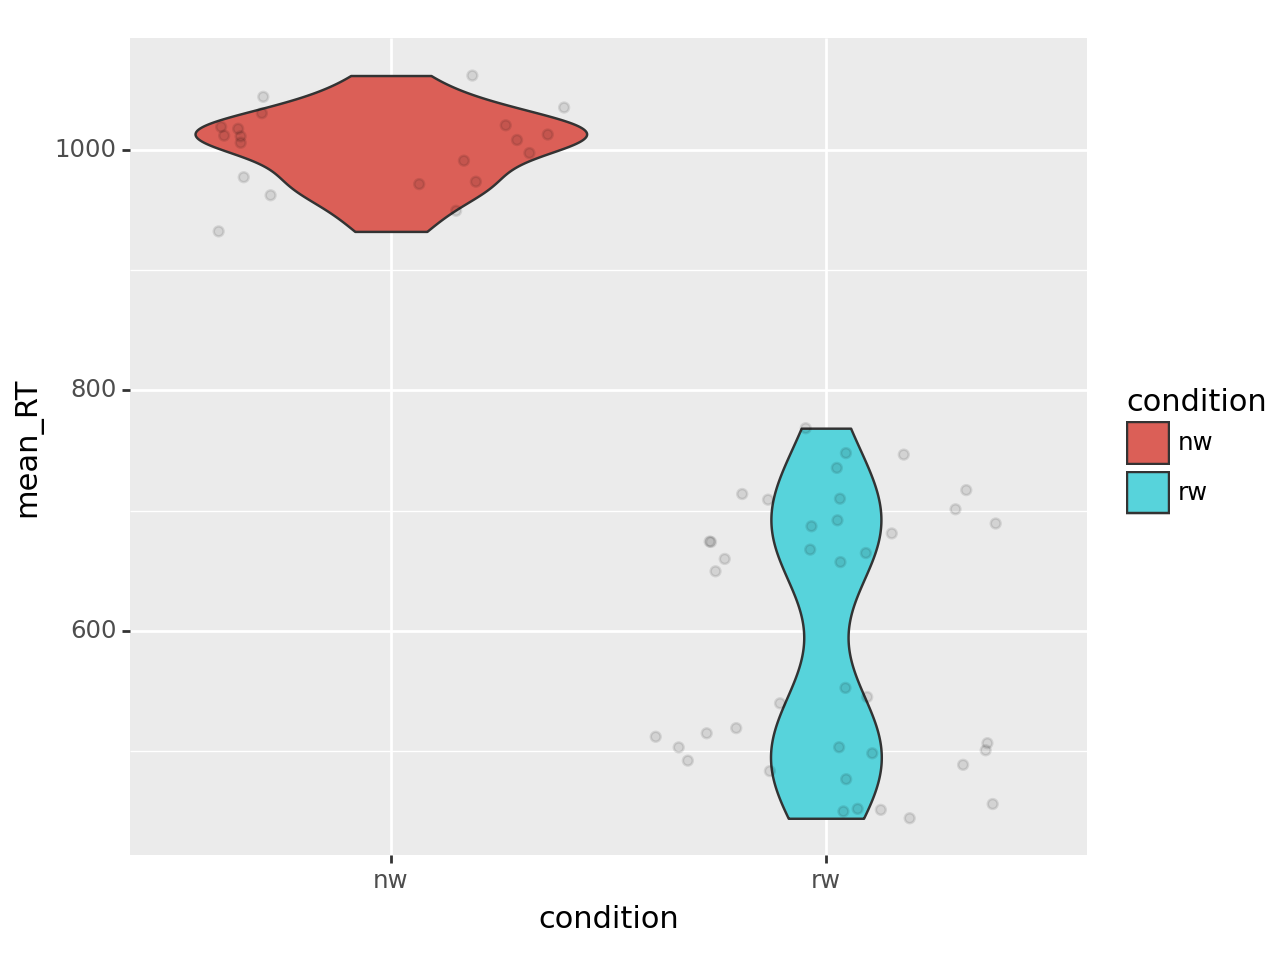

In [69]:
import plotnine as gg
from plotnine import ggplot

# Calculate mean RT and ACC for each participant

summary = trials.groupby(['id','freq_category','condition']).aggregate(
    mean_RT=pd.NamedAgg('ResponseTime', np.mean),
    std_RT=pd.NamedAgg('ResponseTime', np.std),
    mean_ACC=pd.NamedAgg('Accuracy', np.mean),
    std_ACC=pd.NamedAgg('Accuracy', np.std)
)

summary.reset_index(inplace=True)

# Aggregate plot (violin plot)

plot = (
    ggplot(data=summary) +
    gg.aes(x='condition', y='mean_RT') +
    gg.geom_violin(gg.aes(fill='condition')) +
    gg.geom_point(position='jitter',alpha=0.1)
)
plot.draw()
#plt.show()



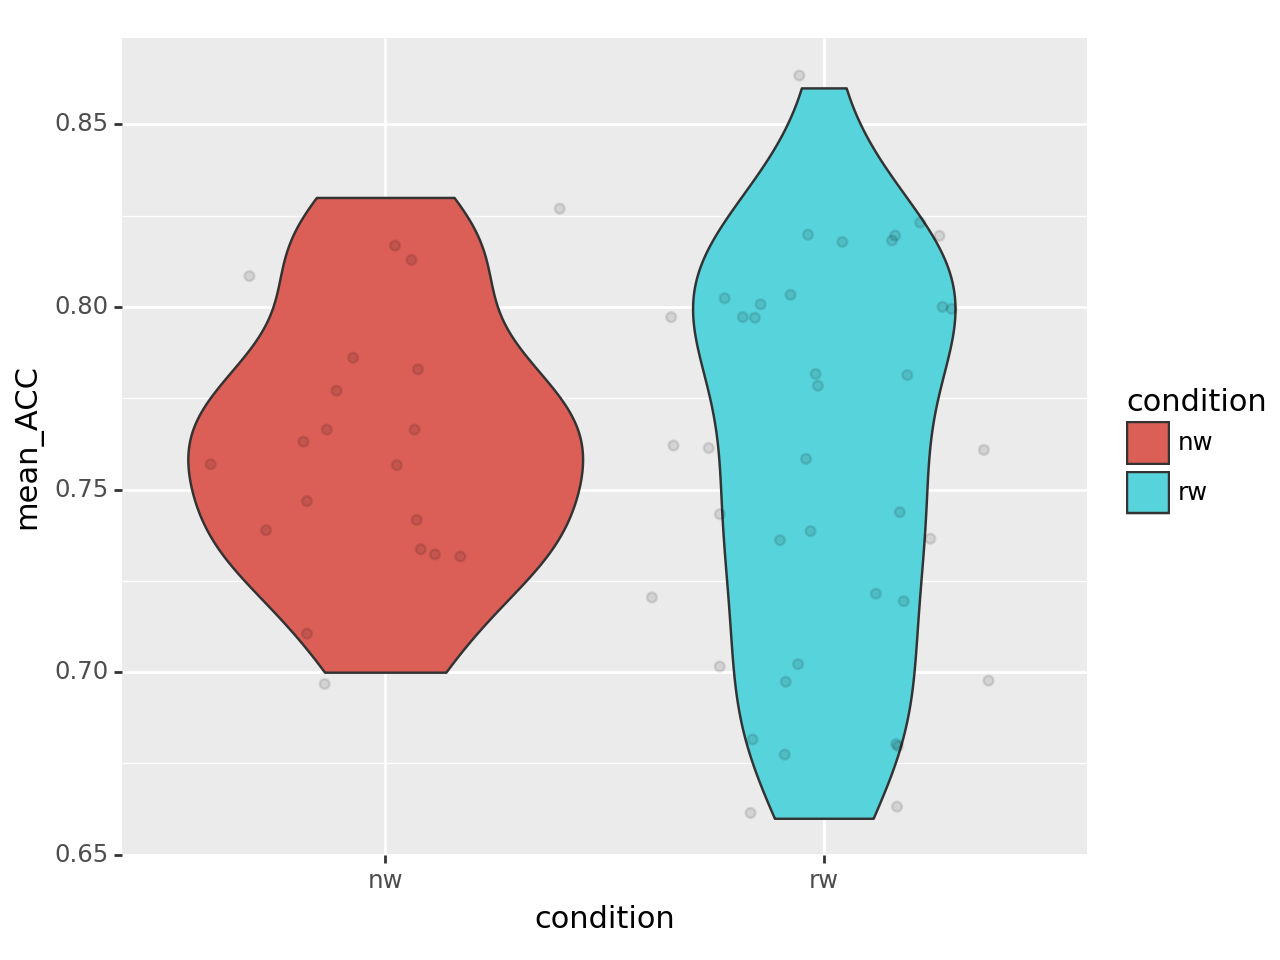

In [70]:

plot = (
    ggplot(data=summary) +
    gg.aes(x='condition', y='mean_ACC') +
    gg.geom_violin(gg.aes(fill='condition')) +
    gg.geom_point(position='jitter',alpha=0.1)
)
plot.draw()
#plt.show()

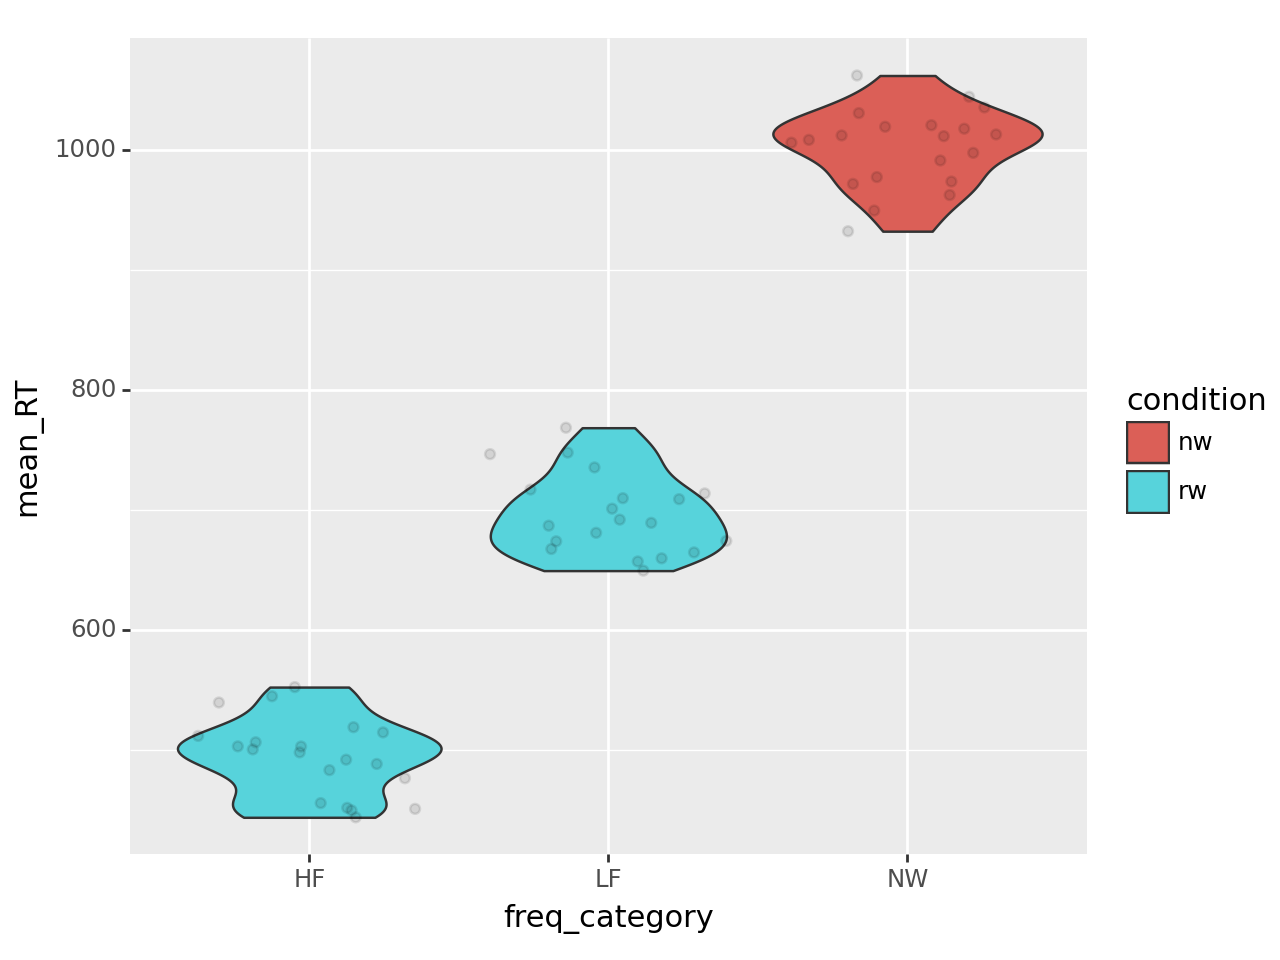

In [71]:
plot = (
    ggplot(data=summary) +
    gg.aes(x='freq_category', y='mean_RT') +
    gg.geom_violin(gg.aes(fill='condition')) +
    gg.geom_point(position='jitter',alpha=0.1)
)
plot.draw()
#plt.show()

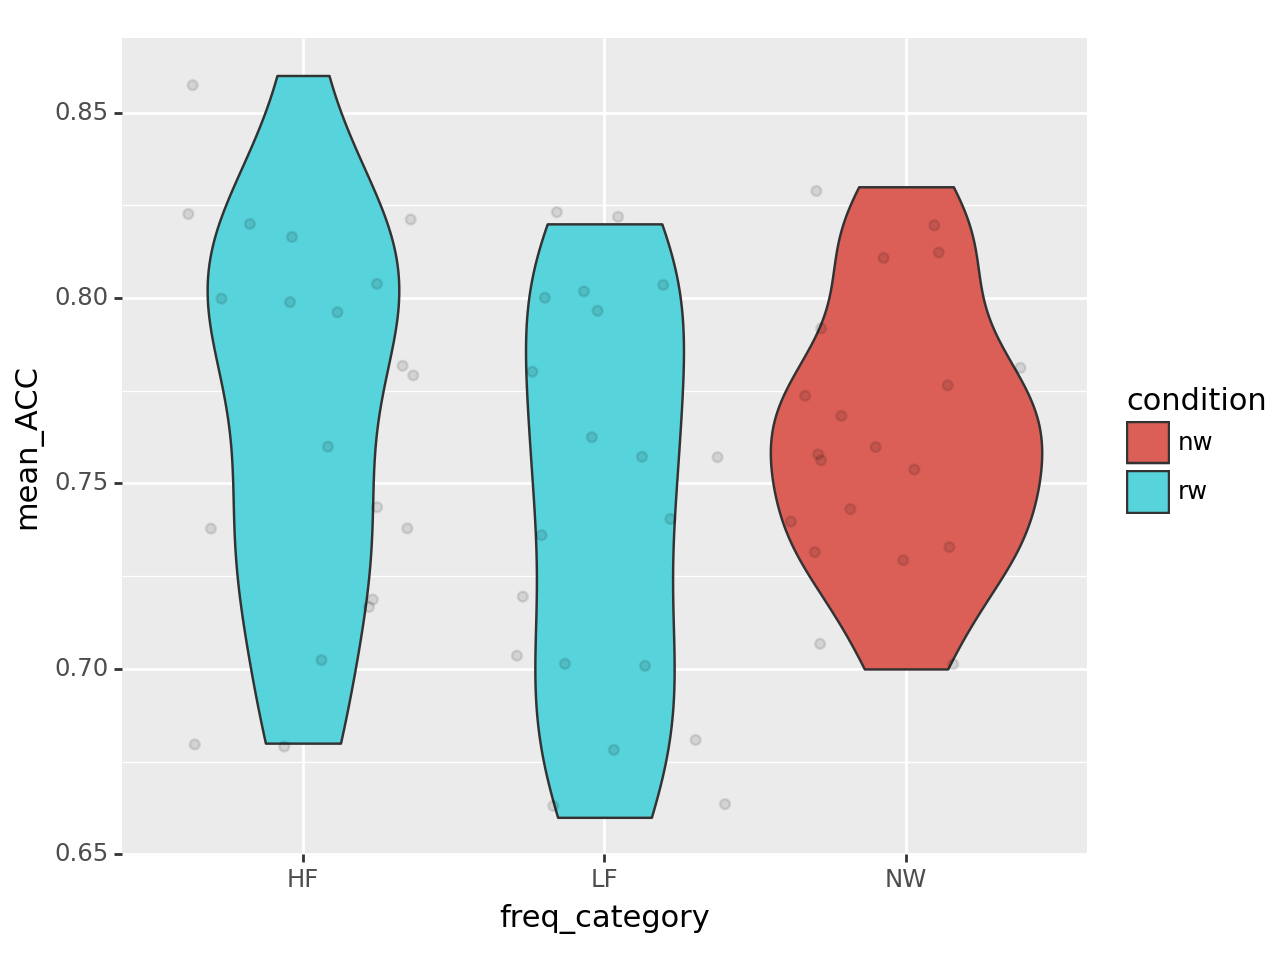

In [72]:
plot = (
    ggplot(data=summary) +
    gg.aes(x='freq_category', y='mean_ACC') +
    gg.geom_violin(gg.aes(fill='condition')) +
    gg.geom_point(position='jitter',alpha=0.1)
)
plot.draw()
#plt.show()

In [77]:
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

# Repeated-measure ANOVA
aov = AnovaRM(
    trials,
    depvar='ResponseTime',
    subject='id',
    within=['condition'],
    aggregate_func='mean'
).fit()

print(aov) # for mean RT in different lexicality 

aov = AnovaRM(
    trials,
    depvar='ResponseTime',
    subject='id',
    within=['freq_category'],
    aggregate_func='mean'
).fit()

print(aov) # for mean RT in different frequency (separate these two variables since they're nested)



                  Anova
           F Value  Num DF  Den DF Pr > F
-----------------------------------------
condition 2648.4189 1.0000 19.0000 0.0000

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
freq_category 1038.3198 2.0000 38.0000 0.0000

